# Prediksi Kucing dan Anjing

In [107]:
import os
import requests
from pathlib import Path
import zipfile
import shutil
import math

from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Periksa dataset

In [109]:
image_path = Path("data/cat_and_dogs_filtered")

print(f"train cat: {len(os.listdir(image_path / 'train' / 'cat'))}")
print(f"train dog: {len(os.listdir(image_path / 'train' / 'dog'))}")
print(f"valid cat: {len(os.listdir(image_path / 'validation' / 'cat'))}")
print(f"valid dog: {len(os.listdir(image_path / 'validation' / 'dog'))}")

train cat: 9375
train dog: 9375
valid cat: 3125
valid dog: 3125


In [94]:
train_dir = image_path / "train"
valid_dir = image_path / "validation"
print(train_dir)
print(valid_dir)

data/cat_and_dogs_filtered/train
data/cat_and_dogs_filtered/validation


## 2. Modeling using Pretrained Efficient Net

In [95]:
def set_seed(seed : int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def save_model(model : torch.nn.Module, target_dir : str, model_name : str):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)
    
    assert model_name.endswith(".pth")
    model_save_path = target_dir_path / model_name
    
    print(f"[INFO] Saving model to: {model_save_path}")
    
    torch.save(obj=model.state_dict(), f=model_save_path)

In [96]:
def create_dataloaders(train_dir, valid_dir, train_transform, valid_transform, batch_size, num_workers=os.cpu_count()):
    train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
    valid_data = datasets.ImageFolder(root=valid_dir, transform=valid_transform)
    
    class_names = train_data.classes
    
    train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_dataloader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    
    return train_dataloader, valid_dataloader, class_names

In [97]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # forward model
        y_pred = model(X)
        
        # calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # optimizer zero grad
        optimizer.zero_grad()
        
        # loss backward
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        # calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
        
        
    return train_loss, train_acc

def valid_step(model, dataloader, loss_fn, device):
    model.eval()
    
    valid_loss, valid_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # forward
            y_pred = model(X)
            
            # calculate loss
            loss = loss_fn(y_pred, y)
            valid_loss += loss.item()
            
            # calculcate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            valid_acc += (y_pred_class == y).sum().item() / len(y_pred)
            
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)
            
    return valid_loss, valid_acc

In [98]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
auto_transforms = weights.transforms()
auto_transforms

train_dataloader, valid_dataloader, class_names = create_dataloaders(train_dir=train_dir, 
                                                                     valid_dir=valid_dir,
                                                                     train_transform=auto_transforms,
                                                                     valid_transform=auto_transforms,
                                                                     batch_size=32
                                                                    )

In [99]:
set_seed(1234)
model1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model1.features.parameters():
    param.requires_grad = False
    
output_shape = len(class_names)

model1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True)).to(device)

In [12]:
set_seed(1234)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

epochs = 5

histories = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model=model1, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        device=device
    )
    
    valid_loss, valid_acc = valid_step(
        model=model1,
        dataloader=valid_dataloader,
        loss_fn=loss_fn,
        device=device
    )
    
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"valid_loss: {valid_loss:.4f} | "
        f"valid_acc: {valid_acc:.4f}"
    )
    
    
    # Update results dictionary
    histories["train_loss"].append(train_loss)
    histories["train_acc"].append(train_acc)
    histories["valid_loss"].append(valid_loss)
    histories["valid_acc"].append(valid_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1743 | train_acc: 0.9356 | valid_loss: 0.0974 | valid_acc: 0.9646
Epoch: 2 | train_loss: 0.1258 | train_acc: 0.9506 | valid_loss: 0.0820 | valid_acc: 0.9691
Epoch: 3 | train_loss: 0.1204 | train_acc: 0.9511 | valid_loss: 0.0763 | valid_acc: 0.9702
Epoch: 4 | train_loss: 0.1177 | train_acc: 0.9521 | valid_loss: 0.0778 | valid_acc: 0.9698
Epoch: 5 | train_loss: 0.1178 | train_acc: 0.9522 | valid_loss: 0.0807 | valid_acc: 0.9690


<AxesSubplot:>

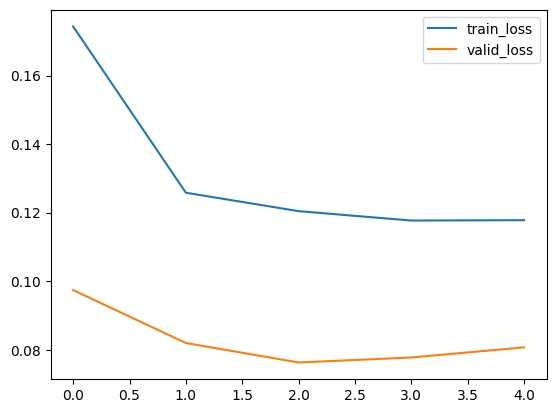

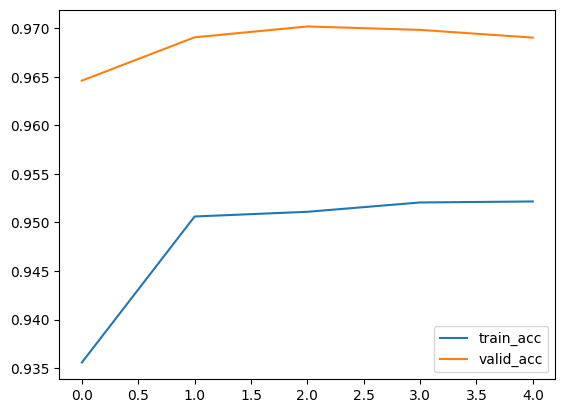

In [13]:
model_1_history_df = pd.DataFrame(histories)
model_1_history_df[['train_loss', 'valid_loss']].plot.line()
model_1_history_df[['train_acc', 'valid_acc']].plot.line()

In [22]:
save_model(model=model1, target_dir="models", model_name="cat_and_dog_effnet_b0.pth")

[INFO] Saving model to: models/cat_and_dog_effnet_b0.pth


## 3. Tes model

In [185]:
def test_model(model, tensor_image, device):
    model.eval()
    with torch.inference_mode():
        target_image = tensor_image.unsqueeze(dim=0)
        pred = model(target_image.to(device))
    
    pred_prob = torch.softmax(pred, dim=1)
    return torch.argmax(pred_prob, dim=1).item(),  torch.max(pred_prob).item()
        

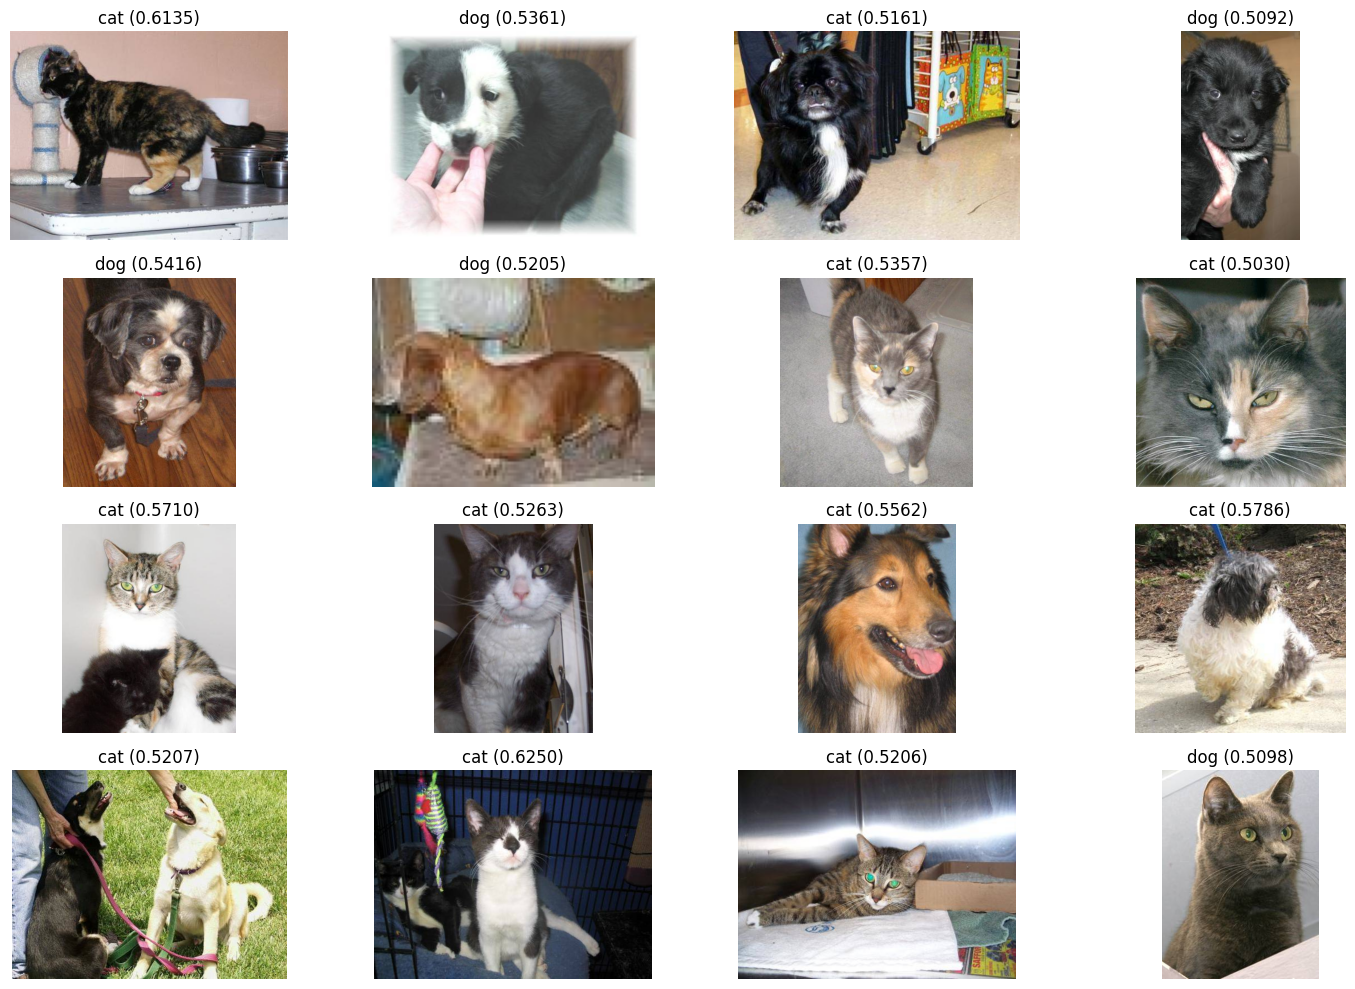

In [194]:
random.seed(42)
label_names = ['cat', 'dog']
random_image_paths = random.sample(os.listdir(image_path / "test"), k=16)

cols = 4
rows = 4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    filename = image_path / "test" / random_image_paths[i]
    with Image.open(filename) as f:
        img = auto_transforms(f)
        label_num, prob = test_model(model=model1, tensor_image=img, device=device)
        ax.set_title(f"{label_names[label_num]} ({prob:.4f})")
        ax.imshow(f, cmap='gray')
        ax.axis('off')
        
plt.tight_layout()
plt.show()